In [ ]:
!pip install pandas
!pip install matplotlib

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import re

2025-09-16 11:51:17.322152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
df = pd.read_csv("/Users/jameshill/PycharmProjects/bioacoustic-classifier/src/data/annotations/spectrogram_labels.csv")
df['filepath'] = "/Users/jameshill/PycharmProjects/bioacoustic-classifier/data/processed/spectrogram_3s/" + df['filename'] + ".png"
df['split_labels'] = df['label'].str.split('_and_')

In [9]:
classes = df.explode('split_labels')
classes

,filename,label,filepath,split_labels
0,20240611_050000_chunk_706_eurasian_skylark_and...,eurasian_skylark_and_yellowhammer,/Users/jameshill/PycharmProjects/bioacoustic-c...,eurasian_skylark
0,20240611_050000_chunk_706_eurasian_skylark_and...,eurasian_skylark_and_yellowhammer,/Users/jameshill/PycharmProjects/bioacoustic-c...,yellowhammer
1,20240611_050000_chunk_1002_background_noise,background_noise,/Users/jameshill/PycharmProjects/bioacoustic-c...,background_noise
2,20240611_050000_chunk_722_background_noise,background_noise,/Users/jameshill/PycharmProjects/bioacoustic-c...,background_noise
3,20240611_050000_chunk_689_eurasian_skylark,eurasian_skylark,/Users/jameshill/PycharmProjects/bioacoustic-c...,eurasian_skylark
...,...,...,...,...
1439,20240612_050000_chunk_049_background_noise_and...,background_noise_and_blackcap,/Users/jameshill/PycharmProjects/bioacoustic-c...,blackcap
1440,20240611_050000_chunk_445_carrion_crow_and_yel...,carrion_crow_and_yellowhammer,/Users/jameshill/PycharmProjects/bioacoustic-c...,carrion_crow
1440,20240611_050000_chunk_445_carrion_crow_and_yel...,carrion_crow_and_yellowhammer,/Users/jameshill/PycharmProjects/bioacoustic-c...,yellowhammer
1441,20240611_050000_chunk_304_eurasian_skylark,eurasian_skylark,/Users/jameshill/PycharmProjects/bioacoustic-c...,eurasian_skylark


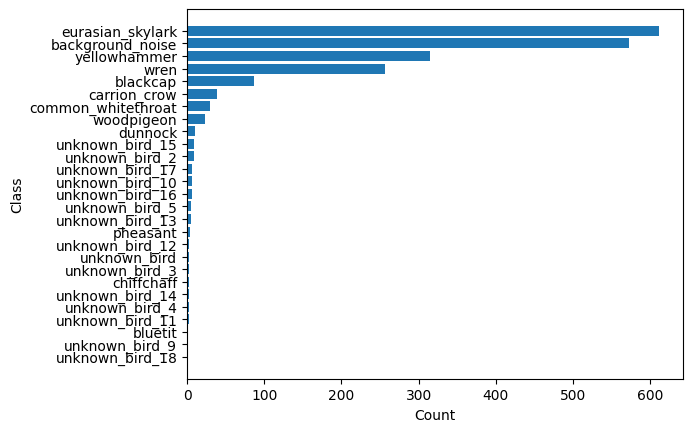

In [29]:
# Class balance/ imbalance
counts = classes['split_labels'].value_counts(ascending=True)
plt.barh(range(len(counts)), counts.values)
plt.yticks(range(len(counts)), counts.index)
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()

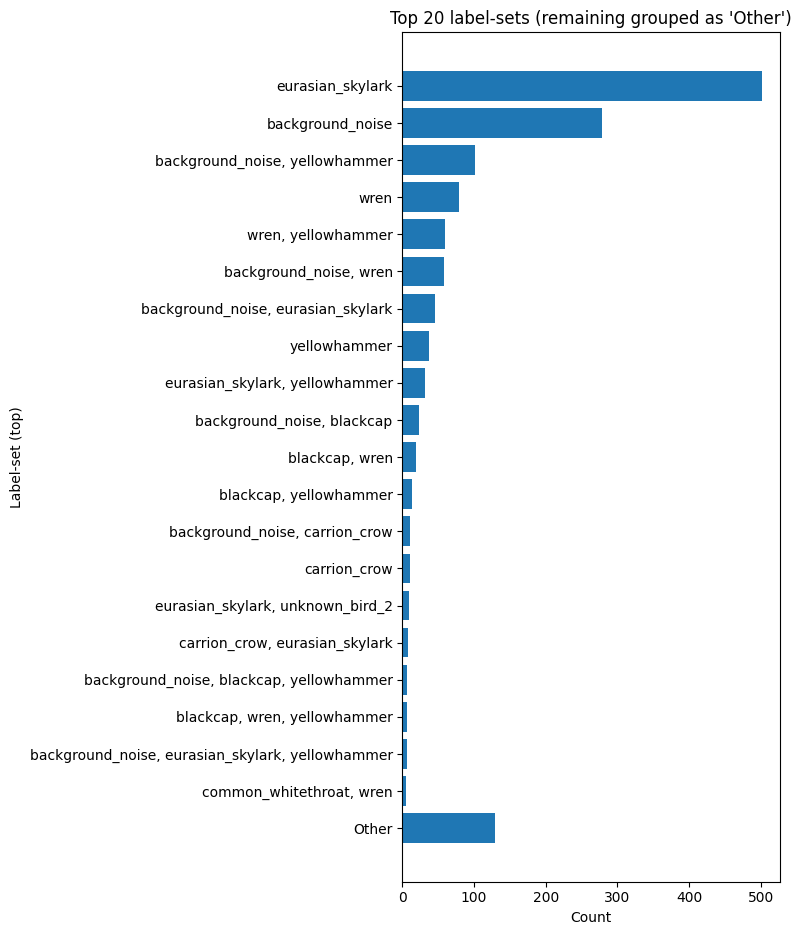

In [35]:
from collections import Counter

# Canonicalize each label-set as a tuple (sorted to merge permutations)
labelsets = df["split_labels"].apply(lambda L: tuple(sorted(L)))
ls_counts = Counter(labelsets)

# Keep top-N and group the rest
N = 20  # adjust
top = ls_counts.most_common(N)
top_labels = [", ".join(k) if k else "(empty)" for k, _ in top]
top_values = [v for _, v in top]

# Sum the rest into "Other"
other = sum(v for (k, v) in ls_counts.items() if (k, v) not in top)

if other > 0:
    top_labels.append("Other")
    top_values.append(other)

# Plot (horizontal), optionally on log-x if very skewed
plt.figure(figsize=(8, 0.45 * len(top_labels)))
plt.barh(top_labels[::-1], top_values[::-1])  # reverse to show largest at top
plt.xlabel("Count")
plt.ylabel("Label-set (top)")
plt.title(f"Top {N} label-sets (remaining grouped as 'Other')")
# Uncomment for heavy skew:
# plt.xscale("log")
plt.tight_layout()
plt.show()


In [12]:
# use a set as duplicates aren't permitted
all_labels = set()
for loc in df['label']:
    species = loc.split('_and_')
    all_labels.update(species)
all_labels

{'background_noise',
 'blackcap',
 'bluetit',
 'carrion_crow',
 'chiffchaff',
 'common_whitethroat',
 'dunnock',
 'eurasian_skylark',
 'pheasant',
 'unknown_bird',
 'unknown_bird_10',
 'unknown_bird_11',
 'unknown_bird_12',
 'unknown_bird_13',
 'unknown_bird_14',
 'unknown_bird_15',
 'unknown_bird_16',
 'unknown_bird_17',
 'unknown_bird_18',
 'unknown_bird_2',
 'unknown_bird_3',
 'unknown_bird_4',
 'unknown_bird_5',
 'unknown_bird_9',
 'woodpigeon',
 'wren',
 'yellowhammer'}

In [5]:
df['split_labels'] = df['label'].str.split('_and_')

In [36]:
from sklearn.preprocessing import MultiLabelBinarizer

mle = MultiLabelBinarizer() 
multi_labels = mle.fit_transform(df['split_labels'])
filepaths = df['filepath'].values
labels = multi_labels

In [40]:
labels[0:5]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]])

In [41]:
df['split_labels'][0:5]

0    [eurasian_skylark, yellowhammer]
1                  [background_noise]
2                  [background_noise]
3                  [eurasian_skylark]
4                  [background_noise]
Name: split_labels, dtype: object

In [47]:
def compute_irlbl_and_weights(y_train, power=0.5, eps=1e-6):
    """
    IRLbl[c] = max_pos / pos_c  (Sampaio et al.)
    Convert IRLbl -> positive-class weights via a soft power (default sqrt)
    and normalize to mean 1 so loss scale stays reasonable.
    """
    pos_per_label = y_train.sum(axis=0).astype(float) + eps
    max_pos = pos_per_label.max()
    irlbl = max_pos / pos_per_label
    # turn IRLbl into weights (so rarer labels get larger weights)
    w = np.power(irlbl, power)
    w = w / (w.mean() + eps)  # normalize to mean ~1
    return irlbl, w
    
irlbl, irlbl_weights = compute_irlbl_and_weights(labels)

# check a few
for i in range(10):
    print(f"class {i}: freq={labels[:, i].sum()} weight={irlbl_weights[i]:.3f}")



class 0: freq=573 weight=0.092
class 1: freq=87 weight=0.236
class 2: freq=1 weight=2.204
class 3: freq=39 weight=0.353
class 4: freq=2 weight=1.558
class 5: freq=30 weight=0.402
class 6: freq=10 weight=0.697
class 7: freq=612 weight=0.089
class 8: freq=4 weight=1.102
class 9: freq=2 weight=1.558


In [10]:
from sklearn.model_selection import train_test_split

# Get arrays
filepaths = df['filepath'].values
labels = multi_labels

# Define preprocessing function
# Preprocessing needed as saving the images as PNGs and then reloading them with decode_png
# This can result in unforeseen issues, so this function adjusts these as a failsafe
def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [64, 512])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# This is where to implement data augmentation
# First, define a set of functions for roll, warping, noise addition
# Next, detect which classes need upsampling
# Duplicate these until they match the size of the most common class
# Apply (randomly) 3 of the 4 possible augmentation techniques to each upsampled instance

# Train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    filepaths, labels, test_size=0.2, random_state=1929
)

# Further split for validation set
training_paths, validation_paths, training_labels, validation_labels = train_test_split(
    train_paths, train_labels, test_size=0.1,random_state=1929
)

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((training_paths, training_labels))
train_ds = train_ds.map(decode_image).shuffle(100).batch(32)

valid_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels))
valid_ds = valid_ds.map(decode_image).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(decode_image).batch(32)

In [12]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 512, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(len(mle.classes_), activation='sigmoid')) # needed for multi-label classificaition


model.compile(optimizer='adam',
              loss='binary_crossentropy', # change to binary crossentropy
              metrics=[
                  keras.metrics.BinaryAccuracy(threshold=0.5),
                  keras.metrics.Precision(thresholds=0.5),
                  keras.metrics.Recall(thresholds=0.5),
                  keras.metrics.AUC(curve='ROC', multi_label=True)
              ])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="first_cnn.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds, 
    epochs=10,
    validation_data=valid_ds, 
    callbacks=callbacks
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - auc_2: 0.3489 - binary_accuracy: 0.8865 - loss: 0.2238 - precision_2: 0.2468 - recall_2: 0.3799 - val_auc_2: 0.3584 - val_binary_accuracy: 0.9624 - val_loss: 0.1121 - val_precision_2: 0.8837 - val_recall_2: 0.2836
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - auc_2: 0.5017 - binary_accuracy: 0.9699 - loss: 0.0853 - precision_2: 0.8133 - recall_2: 0.4595 - val_auc_2: 0.3759 - val_binary_accuracy: 0.9676 - val_loss: 0.1047 - val_precision_2: 0.7765 - val_recall_2: 0.4925
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 429ms/step - auc_2: 0.5938 - binary_accuracy: 0.9728 - loss: 0.0764 - precision_2: 0.8472 - recall_2: 0.5140 - val_auc_2: 0.3675 - val_binary_accuracy: 0.9673 - val_loss: 0.1037 - val_precision_2: 0.7556 - val_recall_2: 0.5075
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - auc_2: 0.6122 - binary_accuracy: 0.9771 - loss: 0.0630 - precision_2: 0.8501 - recall_2: 0.6180 - val_auc_2: 0.3885 - val_binary_accuracy: 

In [15]:
test_model = keras.models.load_model("first_cnn.keras")
test_loss, test_acc, test_precision, test_recall, test_auc = test_model.evaluate(test_ds)
#print(f"Test accuracy: {test_acc:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - auc_2: 0.4443 - binary_accuracy: 0.9716 - loss: 0.0791 - precision_2: 0.7019 - recall_2: 0.6124


In [16]:
test_acc

0.9730655550956726

In [17]:
test_precision

0.7276264429092407

In [18]:
test_recall

0.6275168061256409